# Predicting Price Impact

Here we predict the price impact on trades against the WETH/USDC 0.3% pool on Uniswap v3. We show that a simple OLS regression against trade size gives a very high R^2 value. When using the regression results to predict the amount of token we get out of a trade, we get a very low mean percentage error of <0.01%.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from src.sim.slippage import analyze, process_trades

In [3]:
fn = "../data/slippage/eth_usdc_0_3.csv"
decimals = [18, 6]

with open(fn, "r") as f:
    df = pd.read_csv(f)

df0, df1 = process_trades(df, decimals)

In [4]:
df0.head()

,amount0_adjusted,amount1_adjusted,price_implied,price_actual,previous_price_actual,price_movement_percentage,evt_tx_hash,evt_block_number,evt_block_time,evt_index,price_impact,date
0,40.043899,-0.024662,0.000616,0.000618,0.000618,-1.754502e-07,0x584b5fcd75589d61ccf46fdd9611b4fcb95ea01fe7fd...,15868258.0,2022-10-31 13:11:47.000 UTC,67,-0.003000,2022-10-31
1,3126.994673,-1.925851,0.000616,0.000618,0.000618,-1.370062e-05,0xc06ed09aa8ee6aefc26cf27bb49597d9a78da314d19c...,15868259.0,2022-10-31 13:11:59.000 UTC,187,-0.003007,2022-10-31
2,811.022521,-0.499488,0.000616,0.000618,0.000618,-3.553418e-06,0x3461e21c25bd5d48792fb382c2b6edf11fcd5cfd9a1e...,15868279.0,2022-10-31 13:15:59.000 UTC,166,-0.003002,2022-10-31
3,253801.883288,-156.222856,0.000616,0.000617,0.000618,-1.111083e-03,0xfc90fbf6f13106ccc2201630c8666bc93036823b6ebf...,15868285.0,2022-10-31 13:17:11.000 UTC,5,-0.003554,2022-10-31
4,596.667082,-0.367062,0.000615,0.000617,0.000617,-2.612784e-06,0xeeac0325bd17bdfede8e78c0c0b50fe9d13df618b61c...,15868288.0,2022-10-31 13:17:47.000 UTC,116,-0.003001,2022-10-31


In [5]:
print(f"Mean price impact: {df0['price_impact'].mean():.5f}")
print(f"Median price impact: {df0['price_impact'].median():.5f}")
print(f"Max price impact: {df0['price_impact'].min():.5f}")
print(f"Min price impact: {df0['price_impact'].max():.5f}")
median = df0["price_impact"].median()

Mean price impact: -0.00317
Median price impact: -0.00302
Max price impact: -0.02210
Min price impact: -0.00300


Mean percentage error: 0.004%
Mean percentage error: 0.006%

Coefficients:
[[ 0.00000000e+00 -2.82545974e-09]
 [-3.97739956e-06  0.00000000e+00]]

Intercepts:
[[ 0.         -0.00300451]
 [-0.00301359  0.        ]]

Results:
[[0.         0.91565548]
 [0.86055151 0.        ]]


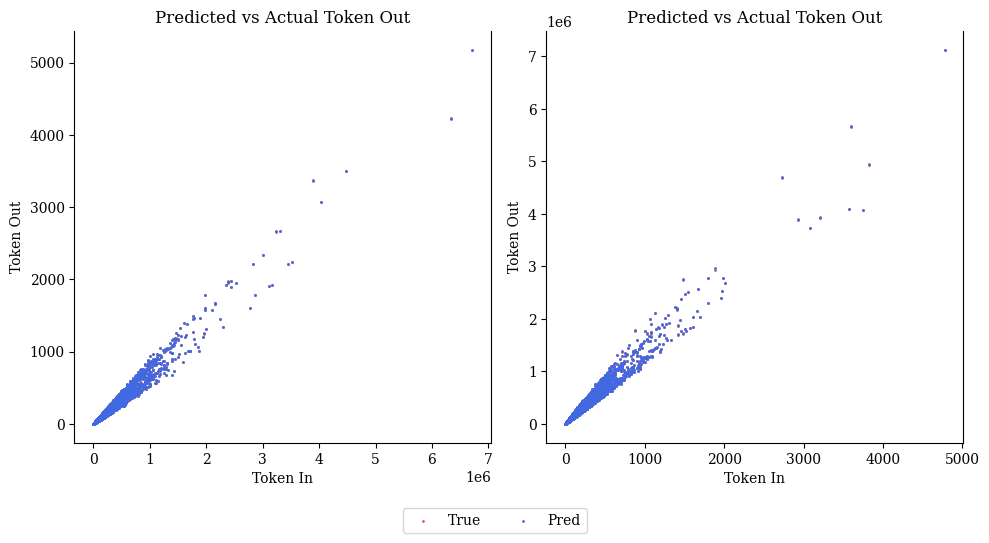

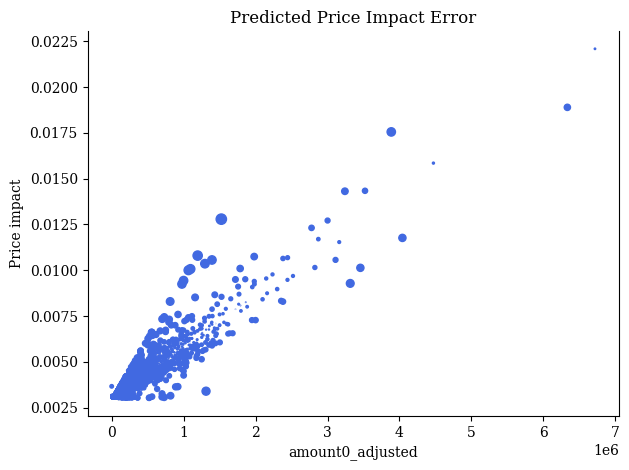

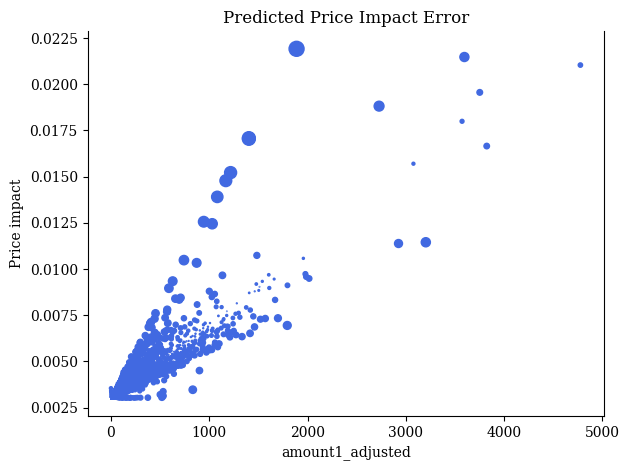

In [6]:
fn = "../data/slippage/eth_usdc_0_3.csv"
decimals = [18, 6]

coefs, intercepts, results, df0, df1 = analyze(fn, decimals, plot=True, return_dfs=True)
print(f"\nCoefficients:\n{coefs}")
print(f"\nIntercepts:\n{intercepts}")
print(f"\nResults:\n{results}")

In [7]:
description = df0["pct_error"].describe()
for item in description.keys():
    if item != "count":
        print(f"{item}: {description[item]:.5f}%")

mean: 0.00390%
std: 0.01132%
min: 0.00000%
25%: 0.00045%
50%: 0.00053%
75%: 0.00331%
max: 0.55527%
